# 생물정보학 및 실습 1 - Term Project (Free Analysis) 2/3
생물정보학 및 실습 1   
서울대학교 협동과정 생물정보학전공 2022년 1학기

In [241]:
from collections import Counter, defaultdict
from itertools import combinations, product
import math
import os
import sys
import pickle
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import pysam
import networkx as nx
from Bio import SeqIO

## 1. Load Dataset and Denoise

In [2]:
dfOctadecamers = pd.read_table('../stats/octadecamers.txt')
dfOctadecamers

,octadecamer,counts
0,GTGGGTAAGAGCACCCGA,18
1,CTTCTGGAGTGTCTGAAG,14
2,AAAAAAAAAAAAAAAAAA,14
3,CATAATTTGTGGTAGTGG,11
4,TTTTTTTTTTTTTTTTTT,8
...,...,...
24724,AGTAATTTGTGCGGGTTT,1
24725,GGTCAAGAGAGTATGAAC,1
24726,ACAGAGCAGTGGTTCTGC,1
24727,CTTAGAACGTGGATGCCA,1


In [3]:
dfOctadecamers = dfOctadecamers[dfOctadecamers.octadecamer.str[8] == 'G'].reset_index(drop=True)
dfOctadecamers

,octadecamer,counts
0,GTGGGTAAGAGCACCCGA,18
1,CTTCTGGAGTGTCTGAAG,14
2,CATAATTTGTGGTAGTGG,11
3,AAATATAAGAGTTCGGTT,5
4,CTTCTGGTGTGTCTGAAG,5
...,...,...
22844,AGTAATTTGTGCGGGTTT,1
22845,GGTCAAGAGAGTATGAAC,1
22846,ACAGAGCAGTGGTTCTGC,1
22847,CTTAGAACGTGGATGCCA,1


In [4]:
dfOctadecamers['hexamer'] = dfOctadecamers.octadecamer.str[6:12]
dfOctadecamers

,octadecamer,counts,hexamer
0,GTGGGTAAGAGCACCCGA,18,AAGAGC
1,CTTCTGGAGTGTCTGAAG,14,GAGTGT
2,CATAATTTGTGGTAGTGG,11,TTGTGG
3,AAATATAAGAGTTCGGTT,5,AAGAGT
4,CTTCTGGTGTGTCTGAAG,5,GTGTGT
...,...,...,...
22844,AGTAATTTGTGCGGGTTT,1,TTGTGC
22845,GGTCAAGAGAGTATGAAC,1,GAGAGT
22846,ACAGAGCAGTGGTTCTGC,1,CAGTGG
22847,CTTAGAACGTGGATGCCA,1,ACGTGG


In [15]:
ENRICH_CUTOFF = 10

In [16]:
dfHexamers = dfOctadecamers.groupby('hexamer').sum().sort_values('counts', ascending=False)
dfHexamers = dfHexamers[dfHexamers.counts >= ENRICH_CUTOFF]
dfHexamers

,counts
hexamer,
AAGGAG,591
AAGAAG,426
AAGAGA,368
AAGAGG,363
GAGGAG,354
...,...
TTGCGC,10
CGGGGG,10
GGGGAT,10


## 2. Make PSSM

In [39]:
dctEncoding = {'A':0, 'C':1, 'G':2, 'T':3}
for i in range(6):
    dfHexamers[f'{i}'] = dfHexamers.index.to_series().str.get(i).apply(lambda x: dctEncoding[x])
dfHexamers.reset_index(drop=False, inplace=True)
dfHexamers

,hexamer,counts,0,1,2,3,4,5
0,AAGGAG,591,0,0,2,2,0,2
1,AAGAAG,426,0,0,2,0,0,2
2,AAGAGA,368,0,0,2,0,2,0
3,AAGAGG,363,0,0,2,0,2,2
4,GAGGAG,354,2,0,2,2,0,2
...,...,...,...,...,...,...,...,...
404,TTGCGC,10,3,3,2,1,2,1
405,CGGGGG,10,1,2,2,2,2,2
406,GGGGAT,10,2,2,2,2,0,3
407,GGGGAA,10,2,2,2,2,0,0


In [47]:
arrPfm = np.zeros((4, 6), dtype=np.int64)

for idx in range(len(dfHexamers)):
    for j in range(6):
        i = dfHexamers.loc[idx, f'{j}']
        arrPfm[i, j] += dfHexamers.loc[idx, 'counts']
arrPfm

array([[ 9015,  9481,     0,  8555,  5427,  5410],
       [ 3615,  1201,     0,  1402,   589,  1781],
       [ 4205,  4290, 21274,  6968, 12031, 10712],
       [ 4439,  6302,     0,  4349,  3227,  3371]])

In [210]:
arrPpm = arrPfm / arrPfm.sum(axis=0)
print(arrPpm)

[[0.4237567  0.44566137 0.         0.40213406 0.25510012 0.25430102]
 [0.16992573 0.05645389 0.         0.06590204 0.02768638 0.08371721]
 [0.19765911 0.2016546  1.         0.32753596 0.56552599 0.50352543]
 [0.20865846 0.29623014 0.         0.20442794 0.15168751 0.15845633]]


In [200]:
dctMonoNucs = Counter()
iterFa = SeqIO.parse('../data/fa/gencode.vM28.transcripts.fa', format='fasta')
for seq in iterFa:
    sGeneId = seq.name.split('|')[1]
    sSeq = str(seq.seq).upper()
    dctMonoNucs.update(sSeq)

In [205]:
arrBgCounts = np.array([
    dctMonoNucs['A'],
    dctMonoNucs['C'],
    dctMonoNucs['G'],
    dctMonoNucs['T']
])
arrBgCounts

array([63706005, 58223783, 59183257, 61055252])

In [207]:
arrBgFreq = arrBgCounts / arrBgCounts.sum()
arrBgFreq

array([0.26306501, 0.24042694, 0.24438895, 0.2521191 ])

In [219]:
arrPssm = np.log2(arrPpm + 1) - np.log2([list(arrBgFreq),] * 6).T
print(arrPssm)

[[2.43621137 2.45823839 1.92650874 2.41413303 2.25431119 2.25339236]
 [2.28274647 2.13555932 2.05632953 2.14840438 2.09572959 2.17231787]
 [2.29296635 2.29777128 3.03274901 2.44149995 2.67939647 2.62109828]
 [2.26122933 2.36214459 1.9878227  2.25617078 2.19157202 2.20002637]]


## 3. Network
Draw it only using Top 30 hexamers

In [92]:
dfNodes = dfHexamers[['hexamer', 'counts']].head(20).copy()
dfNodes.head()

,hexamer,counts
0,AAGGAG,591
1,AAGAAG,426
2,AAGAGA,368
3,AAGAGG,363
4,GAGGAG,354


In [93]:
lstNodes = dfNodes.hexamer.to_list()
lstNodes[:5]

['AAGGAG', 'AAGAAG', 'AAGAGA', 'AAGAGG', 'GAGGAG']

In [94]:
def hammingDistance(x, y):
    nmm = 0
    for i in range(len(x)):
        if x[i] != y[i]:
            nmm += 1
    return nmm

In [95]:
lstEdges = []
for x, y in combinations(lstNodes, 2):
    if hammingDistance(x, y) == 1:
        lstEdges.append((x, y))

In [96]:
len(lstEdges)

31

In [97]:
lstEdges[:5]

[('AAGGAG', 'AAGAAG'),
 ('AAGGAG', 'GAGGAG'),
 ('AAGGAG', 'AAGGTG'),
 ('AAGAAG', 'AAGAGG'),
 ('AAGAAG', 'GAGAAG')]

In [121]:
dctNumbers = dfNodes.set_index('hexamer')['counts'].to_dict()
list(dctNumbers.items())[0]

('AAGGAG', 591)

In [122]:
lstColors = [dctNumbers[node] for node in G.nodes()]
lstColors

[591,
 426,
 368,
 363,
 354,
 291,
 217,
 211,
 211,
 210,
 194,
 191,
 188,
 178,
 176,
 172,
 168,
 167,
 167,
 162]

In [98]:
G = nx.Graph()
G.add_nodes_from(lstNodes)
G.add_edges_from(lstEdges)

In [99]:
G

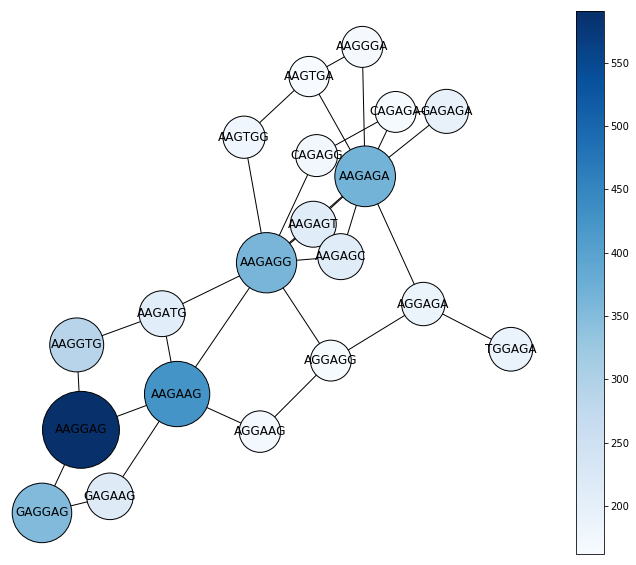

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
nx.draw(G, with_labels=True, ax=ax, node_color=lstColors, node_size=np.array(lstColors) * 10, cmap='Blues', edgecolors='k')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmax=max(lstColors), vmin=min(lstColors)), cmap='Blues')
sm._A = []
plt.colorbar(sm)
plt.savefig('network-lin28a-2206092156.pdf', format='pdf', bbox_inches='tight')

## 4. Predict

+ (Primary) Transcriptome (fasta) was downloaded from GENCODE

In [231]:
fHexamerScore = 0.0
for j, base in enumerate('AAGGAG'):
    i = dctEncoding[base]
    fHexamerScore += arrPpm[i, j]
fHexamerScore

2.9555795807088465

In [221]:
dctGeneScores = {}
iterFa = SeqIO.parse('../data/fa/gencode.vM28.transcripts.fa', format='fasta')
for c, seq in enumerate(iterFa):
    sGeneId = seq.name.split('|')[1]
    sSeq = str(seq.seq).upper()
    fGeneScore = 0.0
    for pos in range(len(sSeq) - 6 + 1):
        fHexamerScore = 0.0
        hexamer = sSeq[pos:pos+6]
        for j, base in enumerate(hexamer):
            i = dctEncoding[base]
            fHexamerScore += arrPssm[i, j]
        if fHexamerScore > fGeneScore:
            fGeneScore = fHexamerScore
    if fGeneScore > dctGeneScores.get(sGeneId, 0):
        dctGeneScores[sGeneId] = fGeneScore
    if c % 2000 == 0:
        print(c)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
106000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000


In [222]:
len(dctGeneScores)

55357

In [223]:
for geneId in dctGeneScores:
    if not geneId.startswith('ENSMUSG'):
        print(geneId, dctGeneScores[geneId])

In [224]:
dfGeneScores = pd.Series(dctGeneScores).to_frame('score')
dfGeneScores = dfGeneScores.sort_values('score').reset_index(drop=False)
dfGeneScores.reset_index(drop=False, inplace=True)
dfGeneScores

,level_0,index,score
0,0,ENSMUSG00000094957.2,13.490334
1,1,ENSMUSG00000096396.2,13.564453
2,2,ENSMUSG00000096884.2,13.564453
3,3,ENSMUSG00000093876.2,13.564453
4,4,ENSMUSG00000078742.2,14.168417
...,...,...,...
55352,55352,ENSMUSG00000107865.2,15.669193
55353,55353,ENSMUSG00000069805.11,15.669193
55354,55354,ENSMUSG00000021456.9,15.669193
55355,55355,ENSMUSG00000035367.10,15.669193


## 5. Threshold?

In [238]:
def query_score(sHexamer):
    fHexamerScore = 0.0
    for j, base in enumerate(sHexamer):
        i = dctEncoding[base]
        fHexamerScore += arrPssm[i, j]
    return fHexamerScore

In [239]:
dfHexamers['score'] = dfHexamers['hexamer'].apply(query_score)
dfHexamers

,hexamer,counts,0,1,2,3,4,5,score
0,AAGGAG,591,0,0,2,2,0,2,15.244108
1,AAGAAG,426,0,0,2,0,0,2,15.216741
2,AAGAGA,368,0,0,2,0,2,0,15.274121
3,AAGAGG,363,0,0,2,0,2,2,15.641827
4,GAGGAG,354,2,0,2,2,0,2,15.100863
...,...,...,...,...,...,...,...,...,...
404,TTGCGC,10,3,3,2,1,2,1,14.656242
405,CGGGGG,10,1,2,2,2,2,2,15.355261
406,GGGGAT,10,2,2,2,2,0,3,14.519324
407,GGGGAA,10,2,2,2,2,0,0,14.572690


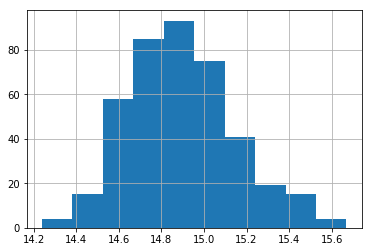

In [240]:
dfHexamers.score.hist()

In [254]:
lst6 = [['A', 'C', 'G', 'T'],] * 6
lst6

[['A', 'C', 'G', 'T'],
 ['A', 'C', 'G', 'T'],
 ['A', 'C', 'G', 'T'],
 ['A', 'C', 'G', 'T'],
 ['A', 'C', 'G', 'T'],
 ['A', 'C', 'G', 'T']]

In [269]:
stNotInSeq = set([''.join(i) for i in product(*lst6)]) - set(dfHexamers.hexamer.to_list())
lstNotInSeq = list(stNotInSeq)
np.random.shuffle(lstNotInSeq)
lstNotInSeq = lstNotInSeq[:409]
lstNotInSeq[:5]

['CACGCG', 'GCCCTG', 'AATTCG', 'CGGCCG', 'CTGTTC']

In [281]:
lstNotInSeqScores = pd.Series(lstNotInSeq).apply(query_score).to_list()
lstNotInSeqScores[:5]

[13.955642207793584,
 13.445929874644929,
 13.855271110109008,
 14.47849901494084,
 14.297700745938748]

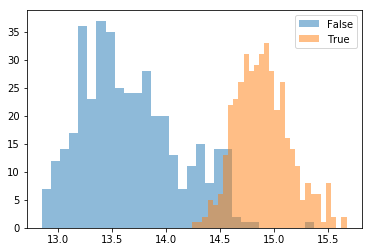

In [293]:
figH, axH = plt.subplots(nrows=1, ncols=1)
axH.hist(lstNotInSeqScores, bins=30, alpha=0.5, label='False')
axH.hist(dfHexamers['score'], bins=30, alpha=0.5, label='True')
axH.legend()
None

In [306]:
lstInSeqScores = dfHexamers['score'].to_list()

In [311]:
ffp = 0
cutoff = 0
for i in sorted(lstNotInSeqScores + lstInSeqScores)[:-2]:
    tp = len([x for x in lstInSeqScores if x > i])
    fp = len([x for x in lstNotInSeqScores if x > i])
    if (fp / (tp + fp)) < 0.05:
        ffp = (fp / (tp + fp))
        cutoff = i
        break

In [312]:
ffp

0.048426150121065374

In [313]:
cutoff

14.509104276512788

In [314]:
SCORE_THRESHOLD = cutoff

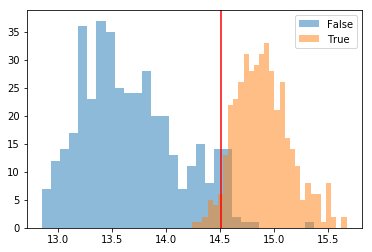

In [315]:
figH, axH = plt.subplots(nrows=1, ncols=1)
axH.hist(lstNotInSeqScores, bins=30, alpha=0.5, label='False')
axH.hist(dfHexamers['score'], bins=30, alpha=0.5, label='True')
axH.legend()

axH.axvline(SCORE_THRESHOLD, c='r')
None

Text(0, 0.5, 'Best score\n(sum of log2 odds ratio)')

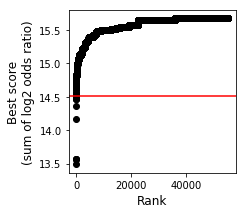

In [317]:
figP, axP = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
axP.scatter('level_0', 'score', data=dfGeneScores, c='k')
axP.axhline(SCORE_THRESHOLD, c='r')
#axP.set_ylim(-0.002, 0.027)
axP.set_xlabel('Rank', fontsize=12)
axP.set_ylabel('Best score\n(sum of log2 odds ratio)', fontsize=12)